# Задание
1. Решите задачу Pong с помощью DQN, используя только полносвязанные слои, оставив только один канал.
2. Число эпизодов и других параметров обучения выберите в соответствии с вычислительной мощностью.

In [1]:
#@title Установка зависимостей
!pip install --upgrade numpy matplotlib torch > /dev/null 2>&1
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=644e21d9efead4b71aa66e3c3da36dda899498578fcdfcf53eb8105b3f6f41ea
  Stored in directory: /root/.cache/pip/wheels/99/f1/ff/c6966c034a8259164bdc9deb4d1ea839f119474638100e6645
Successfully built AutoROM.accept-rom-license


In [2]:
#@title Импорты
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
import time
from PIL import Image

In [3]:
#@title Константы и гиперпараметры
# Параметры среды
ENV_NAME = "ALE/Pong-v5"
OBS_TYPE = "grayscale"  # один канал
RESIZE_SIZE = (84, 84)  # уменьшение размера для полносвязанных слоев
ACTIONS = [0, 2, 3]  # 'NOOP', 'RIGHT', 'LEFT'

# Параметры обучения
N_EPISODES = 200        # количество эпизодов
GAMMA = 0.99            # коэффициент обесценивания
EPSILON_START = 1.0     # начальное значение epsilon
EPSILON_END = 0.01      # конечное значение epsilon
EPSILON_DECAY = 0.995   # коэффициент затухания epsilon
LR = 0.005              # скорость обучения
BATCH_SIZE = 128        # размер батча для experience replay
MEMORY_SIZE = 10000     # размер буфера воспроизведения
TARGET_UPDATE = 10      # частота обновления целевой сети
TRAIN_START = 1000      # минимальный размер буфера перед началом обучения
TRAIN_STEPS = 4         # количество шагов обучения на каждый шаг среды

# Архитектура сети
HIDDEN_SIZE_1 = 512     # размер первого скрытого слоя
HIDDEN_SIZE_2 = 256     # размер второго скрытого слоя

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")


Используется устройство: cuda


In [4]:
#@title Создание среды

def preprocess_observation(obs):
    """
    Предобработка наблюдения: преобразование в grayscale и уменьшение размера.

    Args:
        obs: Наблюдение из среды (numpy array)

    Returns:
        Обработанное наблюдение (numpy array)
    """
    # Если наблюдение уже grayscale (2D массив)
    if len(obs.shape) == 2:
        img = Image.fromarray(obs)
    # Если наблюдение RGB (3D массив)
    elif len(obs.shape) == 3:
        img = Image.fromarray(obs)
        # Преобразование в grayscale, если нужно
        if img.mode != 'L':
            img = img.convert('L')
    else:
        # Если уже одномерный массив, возвращаем как есть
        return obs.astype(np.float32) / 255.0

    # Уменьшение размера
    img = img.resize(RESIZE_SIZE, Image.LANCZOS)

    # Преобразование обратно в numpy array и нормализация
    obs_processed = np.array(img, dtype=np.float32) / 255.0

    return obs_processed

# Создание среды
env = gym.make(ENV_NAME, obs_type=OBS_TYPE)

# Получение размеров
n_action = len(ACTIONS)  # количество доступных действий
n_state = RESIZE_SIZE[0] * RESIZE_SIZE[1]  # размер состояния после flatten

print(f"Количество действий: {n_action}")
print(f"Доступные действия: {ACTIONS}")
print(f"Размер состояния (после flatten): {n_state}")
print(f"Размер наблюдения: {RESIZE_SIZE}")

Количество действий: 3
Доступные действия: [0, 2, 3]
Размер состояния (после flatten): 7056
Размер наблюдения: (84, 84)


In [5]:
#@title Архитектура DQN (полносвязанные слои)

class DQN(nn.Module):
    """
    Глубокая Q-сеть с полносвязанными слоями.
    Принимает на вход одноканальное изображение (flatten).
    """

    def __init__(self, n_state, n_action, hidden_size_1, hidden_size_2):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(n_state, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, n_action)

    def forward(self, x):
        """
        Прямой проход через сеть.

        Args:
            x: Входной тензор (batch_size, n_state)

        Returns:
            Q-значения для каждого действия (batch_size, n_action)
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
#@title Класс агента DQN

class DQNAgent:
    """
    Агент DQN с буфером воспроизведения опыта и целевой сетью.
    """

    def __init__(self, n_state, n_action, hidden_size_1, hidden_size_2, lr, gamma,
                 memory_size, batch_size, target_update):
        self.n_state = n_state
        self.n_action = n_action
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.update_counter = 0

        # Создание Q-сети и целевой сети
        self.q_network = DQN(n_state, n_action, hidden_size_1, hidden_size_2).to(device)
        self.target_network = DQN(n_state, n_action, hidden_size_1, hidden_size_2).to(device)

        # Копирование весов в целевую сеть
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Оптимизатор
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Буфер воспроизведения
        self.memory = deque(maxlen=memory_size)

    def remember(self, state, action, reward, next_state, done):
        """
        Сохранение перехода в буфер воспроизведения.

        Args:
            state: Текущее состояние
            action: Выбранное действие
            reward: Полученное вознаграждение
            next_state: Следующее состояние
            done: Флаг завершения эпизода
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, epsilon):
        """
        Выбор действия по ε-жадной стратегии.

        Args:
            state: Текущее состояние
            epsilon: Вероятность случайного действия

        Returns:
            Выбранное действие
        """
        if random.random() < epsilon:
            return random.randrange(self.n_action)

        state_tensor = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return q_values.argmax().item()

    def replay(self):
        """
        Обучение сети на случайной выборке из буфера воспроизведения.

        Returns:
            Значение функции потерь
        """
        if len(self.memory) < TRAIN_START:
            return None

        # Выборка случайного батча
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Преобразование в тензоры (сначала в numpy array для эффективности)
        states_array = np.array([s.flatten() for s in states])
        states = torch.FloatTensor(states_array).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states_array = np.array([s.flatten() for s in next_states])
        next_states = torch.FloatTensor(next_states_array).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # Текущие Q-значения
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Целевые Q-значения
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        # Вычисление потерь
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        # Обновление сети
        self.optimizer.zero_grad()
        loss.backward()
        # Градиентное клиппирование для стабильности
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        # Обновление целевой сети
        self.update_counter += 1
        if self.update_counter % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()


In [7]:
#@title Функция обучения

def train_agent(env, agent, n_episodes, epsilon_start, epsilon_end, epsilon_decay):
    """
    Обучение агента DQN.

    Args:
        env: Среда Gymnasium
        agent: Агент DQN
        n_episodes: Количество эпизодов обучения
        epsilon_start: Начальное значение epsilon
        epsilon_end: Конечное значение epsilon
        epsilon_decay: Коэффициент затухания epsilon

    Returns:
        episode_rewards: Список вознаграждений по эпизодам
        episode_steps: Список количества шагов по эпизодам
        best_episode_sequence: Последовательность действий лучшего эпизода
    """
    episode_rewards = []
    episode_steps = []
    epsilon = epsilon_start
    best_reward = float('-inf')
    best_episode_sequence = []

    # Интервал вывода прогресса (10% от количества эпизодов)
    print_interval = max(1, n_episodes // 10)

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = preprocess_observation(state)

        total_reward = 0
        steps = 0
        episode_sequence = []

        while True:
            # Выбор действия (индекс в ACTIONS)
            action_idx = agent.act(state, epsilon)
            # Маппинг на реальное действие среды
            action = ACTIONS[action_idx]
            episode_sequence.append(action)

            # Выполнение действия
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_observation(next_state)

            # Сохранение в буфер (сохраняем индекс действия, а не реальное действие)
            agent.remember(state, action_idx, reward, next_state, done)

            # Обучение
            for _ in range(TRAIN_STEPS):
                loss = agent.replay()

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        # Обновление epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Сохранение результатов
        episode_rewards.append(total_reward)
        episode_steps.append(steps)

        # Обновление лучшего эпизода
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode_sequence = episode_sequence.copy()

        # Вывод прогресса
        if (episode + 1) % print_interval == 0:
            avg_reward = np.mean(episode_rewards[-print_interval:])
            print(f"Эпизод {episode + 1}/{n_episodes} | "
                  f"Средний результат={avg_reward:.2f} | "
                  f"Лучший результат={best_reward:.2f} | "
                  f"Epsilon={epsilon:.3f}")

    print(f"\nОбучение завершено.")
    print(f"Лучшее вознаграждение: {best_reward:.2f}")
    print(f"Среднее вознаграждение (последние 10 эпизодов): {np.mean(episode_rewards[-10:]):.2f}")

    return episode_rewards, episode_steps, best_episode_sequence


In [8]:
#@title Обучение агента

# Создание агента
agent = DQNAgent(
    n_state=n_state,
    n_action=n_action,
    hidden_size_1=HIDDEN_SIZE_1,
    hidden_size_2=HIDDEN_SIZE_2,
    lr=LR,
    gamma=GAMMA,
    memory_size=MEMORY_SIZE,
    batch_size=BATCH_SIZE,
    target_update=TARGET_UPDATE
)

print("Начало обучения...")
start_time = time.time()

# Запуск обучения
episode_rewards, episode_steps, best_episode_sequence = train_agent(
    env=env,
    agent=agent,
    n_episodes=N_EPISODES,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

elapsed_time = time.time() - start_time
print(f"\nОбучение завершено за {elapsed_time:.1f} сек.")

Начало обучения...
Эпизод 20/200 | Средний результат=-20.25 | Лучший результат=-17.00 | Epsilon=0.905
Эпизод 40/200 | Средний результат=-20.65 | Лучший результат=-17.00 | Epsilon=0.818
Эпизод 60/200 | Средний результат=-20.70 | Лучший результат=-17.00 | Epsilon=0.740
Эпизод 80/200 | Средний результат=-20.30 | Лучший результат=-17.00 | Epsilon=0.670
Эпизод 100/200 | Средний результат=-20.65 | Лучший результат=-17.00 | Epsilon=0.606
Эпизод 120/200 | Средний результат=-20.75 | Лучший результат=-17.00 | Epsilon=0.548
Эпизод 140/200 | Средний результат=-20.60 | Лучший результат=-17.00 | Epsilon=0.496
Эпизод 160/200 | Средний результат=-20.85 | Лучший результат=-17.00 | Epsilon=0.448
Эпизод 180/200 | Средний результат=-20.95 | Лучший результат=-17.00 | Epsilon=0.406
Эпизод 200/200 | Средний результат=-20.60 | Лучший результат=-17.00 | Epsilon=0.367

Обучение завершено.
Лучшее вознаграждение: -17.00
Среднее вознаграждение (последние 10 эпизодов): -20.60

Обучение завершено за 5838.8 сек.


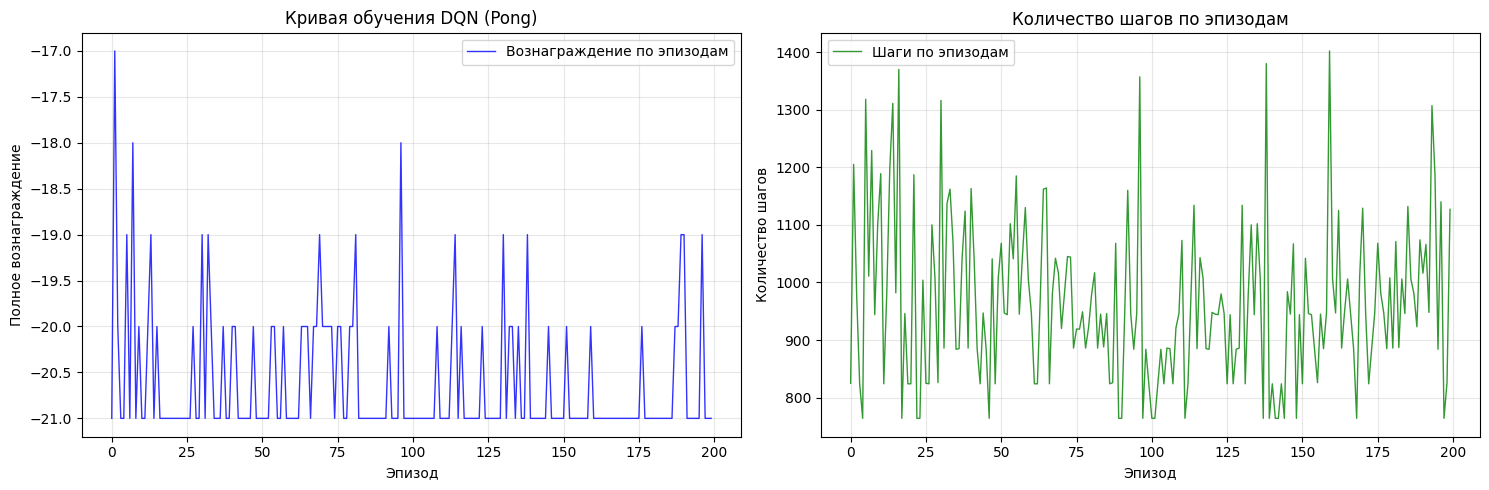

In [9]:
#@title Графики

plt.figure(figsize=(15, 5))

# График вознаграждений
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, alpha=0.8, color='blue', linewidth=1, label='Вознаграждение по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.title('Кривая обучения DQN (Pong)')
plt.legend()
plt.grid(True, alpha=0.3)

# График количества шагов
plt.subplot(1, 2, 2)
plt.plot(episode_steps, alpha=0.8, color='green', linewidth=1, label='Шаги по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Количество шагов')
plt.title('Количество шагов по эпизодам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводы по проделанной работе

В рамках данной работы мной была реализована система обучения с подкреплением для среды Pong с использованием алгоритма DQN (Deep Q-Network). Использовалась библиотека PyTorch для создания нейронных сетей и Gymnasium для работы со средой Atari. Была реализована архитектура DQN с полносвязанными слоями, которая принимает на вход одноканальное изображение (grayscale) размером 84x84 пикселей после предобработки.

Для эффективной работы с изображениями была реализована функция предобработки наблюдений, которая преобразует исходные кадры в grayscale формат и уменьшает их размер до 84x84 пикселей, что позволяет использовать полносвязанные слои вместо сверточных. Архитектура нейронной сети состоит из трех полносвязанных слоев с размерами 512 и 256 нейронов в скрытых слоях, что обеспечивает достаточную емкость модели для обучения сложным стратегиям игры.

Для улучшения качества обучения был реализован буфер воспроизведения опыта (experience replay) с размером 10000 переходов, который позволяет агенту обучаться на случайных выборках из прошлого опыта, что повышает стабильность обучения и устраняет корреляции между последовательными переходами. Также была реализована целевая сеть (target network), которая обновляется периодически для стабилизации процесса обучения и решения проблемы движущейся мишени. Я использовал ε-жадную стратегию для баланса между исследованием и эксплуатацией с начальным значением epsilon равным 1.0 и постепенным уменьшением до 0.01, а также применил градиентное клиппирование для предотвращения взрывающихся градиентов.

Для оптимизации использования вычислительных ресурсов было ограничено пространство действий до трех ключевых действий (NOOP, RIGHT, LEFT), что ускоряет обучение и упрощает задачу для агента. Размер батча был установлен равным 128, а количество шагов обучения на каждый шаг среды составляет 4, что обеспечивает более эффективное использование графического процессора и ускоряет процесс обучения.

В процессе обучения агент демонстрирует прогресс в игре Pong, что подтверждает возможность применения алгоритма DQN с полносвязанными слоями для решения данной задачи.